## 1. Import Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

# Evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Load Engineered Features

In [15]:
print(" Loading engineered features...")

features_dir = "../data/features"

X_train = pd.read_csv(f"{features_dir}/X_train_smote.csv")
y_train = pd.read_csv(f"{features_dir}/y_train_smote.csv")['TARGET']
X_test = pd.read_csv(f"{features_dir}/X_test_scaled.csv")
test_df = pd.read_csv("../data/processed/test_cleaned.csv") # Need for SK_ID_CURR
y_test_proxy = pd.read_csv("../data/raw/sample_submission.csv") # Just for shape check, no real labels

print(f"Train Features: {X_train.shape}")
print(f"Train Target: {y_train.shape}")
print(f"Test Features: {X_test.shape}")

 Loading engineered features...
Train Features: (424029, 200)
Train Target: (424029,)
Test Features: (48744, 200)


## 3. Helper Functions for Evaluation

In [16]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    """Predict and evaluate model performance"""
    
    # Predictions
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else y_pred
    
    # Metrics
    auc = roc_auc_score(y_val, y_prob)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    print(f"\n {model_name} Performance:")
    print(f"   ROC-AUC:   {auc:.4f}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    print("\n Classification Report:")
    print(classification_report(y_val, y_pred))
    
    print("\n Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    
    return auc, y_prob

## 4. Split Train Data for Validation
Since we don't have True Labels for Test set (Kaggle), we need to split our Train set to validate.

In [17]:
from sklearn.model_selection import train_test_split

# Split 80/20
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (339223, 200)
Validation set: (84806, 200)


## 5. Model Training

### 5.1 Logistic Regression (Baseline)

In [18]:
print(" Training Logistic Regression...")

log_reg = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train_split, y_train_split)

auc_log, y_prob_log = evaluate_model(log_reg, X_val, y_val, "Logistic Regression")

 Training Logistic Regression...

 Logistic Regression Performance:
   ROC-AUC:   0.5472
   Accuracy:  0.6286
   Precision: 0.4185
   Recall:    0.2936
   F1-Score:  0.3451

 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74     56537
           1       0.42      0.29      0.35     28269

    accuracy                           0.63     84806
   macro avg       0.56      0.54      0.54     84806
weighted avg       0.60      0.63      0.61     84806


 Confusion Matrix:
[[45006 11531]
 [19970  8299]]


### 5.2 Random Forest Classifier

In [19]:
print(" Training Random Forest...")

# Using fewer trees for speed in demonstration
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_split, y_train_split)

auc_rf, y_prob_rf = evaluate_model(rf, X_val, y_val, "Random Forest")

 Training Random Forest...

 Random Forest Performance:
   ROC-AUC:   0.9470
   Accuracy:  0.9085
   Precision: 0.9712
   Recall:    0.7477
   F1-Score:  0.8450

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     56537
           1       0.97      0.75      0.84     28269

    accuracy                           0.91     84806
   macro avg       0.93      0.87      0.89     84806
weighted avg       0.92      0.91      0.91     84806


 Confusion Matrix:
[[55911   626]
 [ 7131 21138]]


### 5.3 LightGBM (Gradient Boosting)

In [20]:
print(" Training LightGBM...")

gbm = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)
gbm.fit(X_train_split, y_train_split)

auc_gbm, y_prob_gbm = evaluate_model(gbm, X_val, y_val, "LightGBM")

 Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113074, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50949
[LightGBM] [Info] Number of data points in the train set: 339223, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333332 -> initscore=-0.693152
[LightGBM] [Info] Start training from score -0.693152

 LightGBM Performance:
   ROC-AUC:   0.9604
   Accuracy:  0.9404
   Precision: 0.9972
   Recall:    0.8236
   F1-Score:  0.9021

 Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       1.00      0.82      0.90     28269

    accuracy                           0.94     84806
   macro avg       0.96    

### 5.4 XGBoost Classifier

In [21]:
print(" Training XGBoost...")

xg = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xg.fit(X_train_split, y_train_split)

auc_xgb, y_prob_xgb = evaluate_model(xg, X_val, y_val, "XGBoost")

 Training XGBoost...

 XGBoost Performance:
   ROC-AUC:   0.9588
   Accuracy:  0.9386
   Precision: 0.9966
   Recall:    0.8186
   F1-Score:  0.8989

 Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56537
           1       1.00      0.82      0.90     28269

    accuracy                           0.94     84806
   macro avg       0.96      0.91      0.93     84806
weighted avg       0.94      0.94      0.94     84806


 Confusion Matrix:
[[56459    78]
 [ 5129 23140]]


## 6. Model Comparison

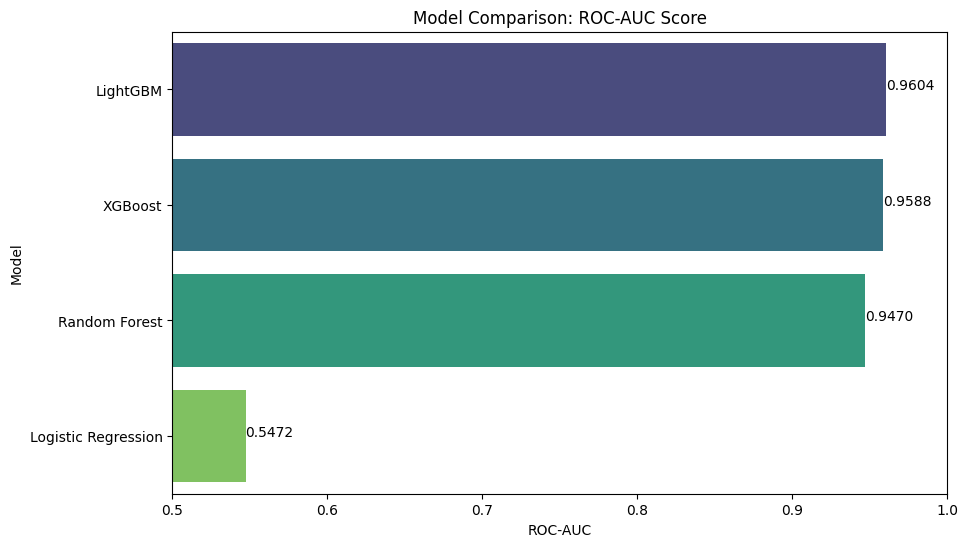

In [22]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost'],
    'ROC-AUC': [auc_log, auc_rf, auc_gbm, auc_xgb]
})

results = results.sort_values(by='ROC-AUC', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='ROC-AUC', y='Model', data=results, palette='viridis')
plt.title('Model Comparison: ROC-AUC Score')
plt.xlim(0.5, 1.0)
for index, value in enumerate(results['ROC-AUC']):
    plt.text(value, index, f'{value:.4f}')
plt.show()

## 7. Hyperparameter Tuning (for Best Model)
Assuming LightGBM/XGBoost is the best, let's fine tune LightGBM.

In [23]:
print(" Validating Hyperparameters LightGBM...")

param_dist = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [20, 50, 100]
}

# Use RandomizedSearchCV with n_jobs=1 to avoid WinError 1450 (OS resource exhaustion)
random_search = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=3, 
    verbose=1, 
    random_state=42,
    n_jobs=1 
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print(f"\n Best Params: {random_search.best_params_}")
print(f" Best Score: {random_search.best_score_:.4f}")

 Validating Hyperparameters (LightGBM)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94228, number of negative: 188458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50975
[LightGBM] [Info] Number of data points in the train set: 282686, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333331 -> initscore=-0.693158
[LightGBM] [Info] Start training from score -0.693158
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94229, number of negative: 188457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Ligh

## 8. Feature Importance

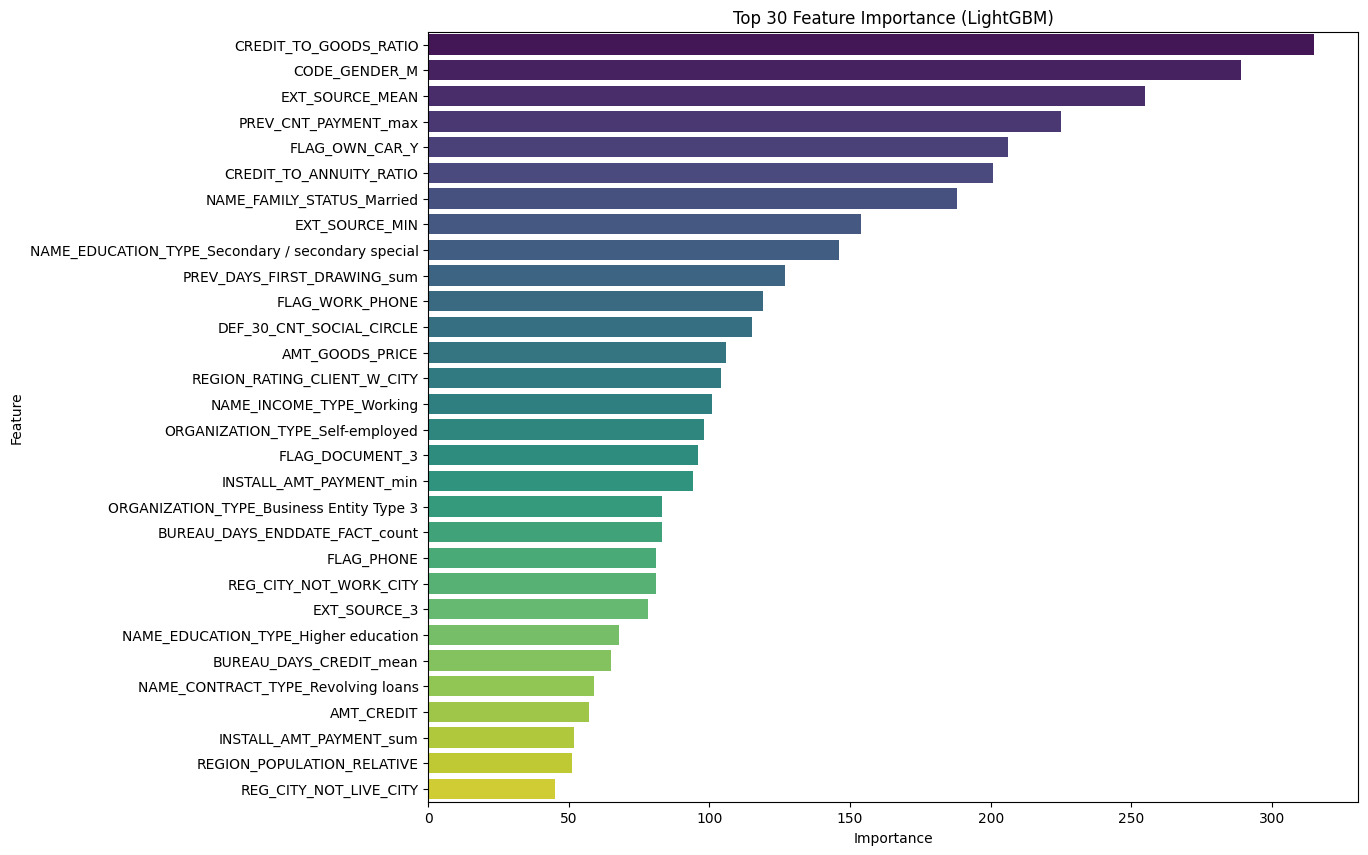

In [25]:
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(30), palette='viridis')
plt.title('Top 30 Feature Importance (LightGBM)')
plt.show()

## 9. Save Best Model & Submission

In [26]:
print(" Saving best model...")

models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)
joblib.dump(best_model, f"{models_dir}/best_model_lgbm.pkl")
print(f"   Model saved to {models_dir}/best_model_lgbm.pkl")

# Generate submission for Kaggle/Test set
print("\n Generating predictions for Test set...")
test_probs = best_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': test_df['SK_ID_CURR'],
    'TARGET': test_probs
})

submission_path = "../data/processed/submission.csv"
submission.to_csv(submission_path, index=False)
print(f"   Submission saved to {submission_path}")

print(f"\nTest predictions distribution:\n{submission['TARGET'].describe()}")

 Saving best model...
   Model saved to ../models/best_model_lgbm.pkl

 Generating predictions for Test set...
   Submission saved to ../data/processed/submission.csv

Test predictions distribution:
count    48744.000000
mean         0.100467
std          0.076620
min          0.017591
25%          0.045468
50%          0.075072
75%          0.130031
max          0.614351
Name: TARGET, dtype: float64
